<a href="https://colab.research.google.com/github/Alejandroll100/Alejandro-Lopez---Processamentos-TCC2/blob/main/Sentinel_SAR_Automatizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MODULE
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from termcolor import colored
from zipfile import ZipFile
from os.path import join
from glob import iglob
import pandas as pd
import numpy as np
import subprocess
import esa_snappy
import jpy

# Change module setting
pd.options.display.max_colwidth = 80

In [ ]:
def output_view(product, band, min_value_VV, max_value_VV, min_value_VH, max_value_VH):
  """
  Creates visualization of processed Sentinel-1 SAR data

  Keyword arguments:
  product      -- snappy GPF product --> input Sentinel-1 product
  band         -- List --> product's band to be visualized
  min_value_VV -- int --> min value for color strech in VV band
  max_value_VV -- int --> max value for color strech in VV band
  min_value_VH -- int --> max value for color strech in VH band
  max_value_VV -- int --> max value for color strech in VH band
  """

  band_data_list = []

  for i in band:
    band = product.getBand(i)
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h, w
    band_data_list.append(band_data)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
  ax1.imshow(band_data_list[0], cmap='gray', vmin=min_value_VV, vmax=max_value_VV)
  ax1.set_title(output_bands[0])
  ax2.imshow(band_data_list[1], cmap='gray', vmin=min_value_VH, vmax=max_value_VH)
  ax2.set_title(output_bands[1])

  for ax in fig.get_axes():
    ax.label_outer()

,Name,Sensing Mode,Product Type,Polarization,Height,Widht,Bands
0,S1C_IW_GRDH_1SDV_20251018T230217_20251018T230247_004622_009248_E8C4_COG,GRDH,1SDV,20251018T230217,19686,25422,"[Amplitude_VV, Intensity_VV, Amplitude_VH, Intensity_VH]"


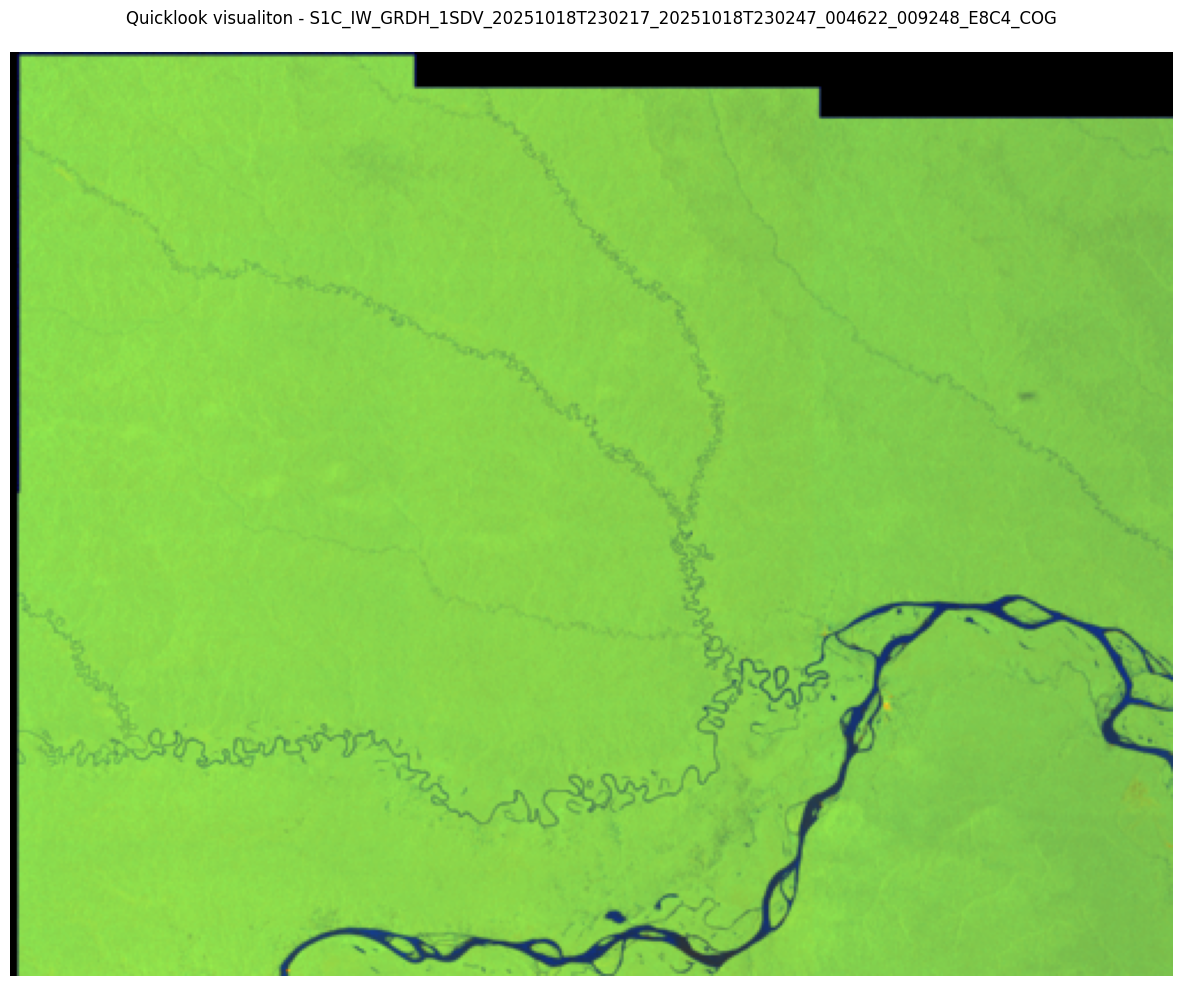

In [ ]:
# Set target folder and extract metadata
product_path = r"C:/Users/lopez/ESA_SNAPPY/teste3"
input_S1_files = sorted(list(iglob(join(product_path, "**", "*S1*.zip"), recursive=True)))

name, sensing_mode, product_type, polarization, height, width, band_names = [[] for i in range(7)]

for i in input_S1_files:
    sensing_mode.append(i.split("_")[3])
    product_type.append(i.split("_")[4])
    polarization.append(i.split("_")[-6])
    # Read with snappy
    s1_read = esa_snappy.ProductIO.readProduct(i)
    name.append(s1_read.getName())
    height.append(s1_read.getSceneRasterHeight())
    width.append(s1_read.getSceneRasterWidth())
    band_names.append(s1_read.getBandNames())

df_s1_read = pd.DataFrame({'Name': name, 'Sensing Mode': sensing_mode, 'Product Type': product_type, 'Polarization': polarization, 'Height': height, 'Widht': width, 'Bands': band_names})
display(df_s1_read)

# Display quicklook - First image
with ZipFile(input_S1_files[0], 'r') as qck_look:
    qck_look = qck_look.open(name[0] + '.SAFE/preview/quick-look.png')
    img = mpimg.imread(qck_look)
    plt.figure(figsize = (15,15))
    plt.title('Quicklook visualiton - ' + name[0] + '\n')
    plt.axis('off')
    plt.imshow(img);

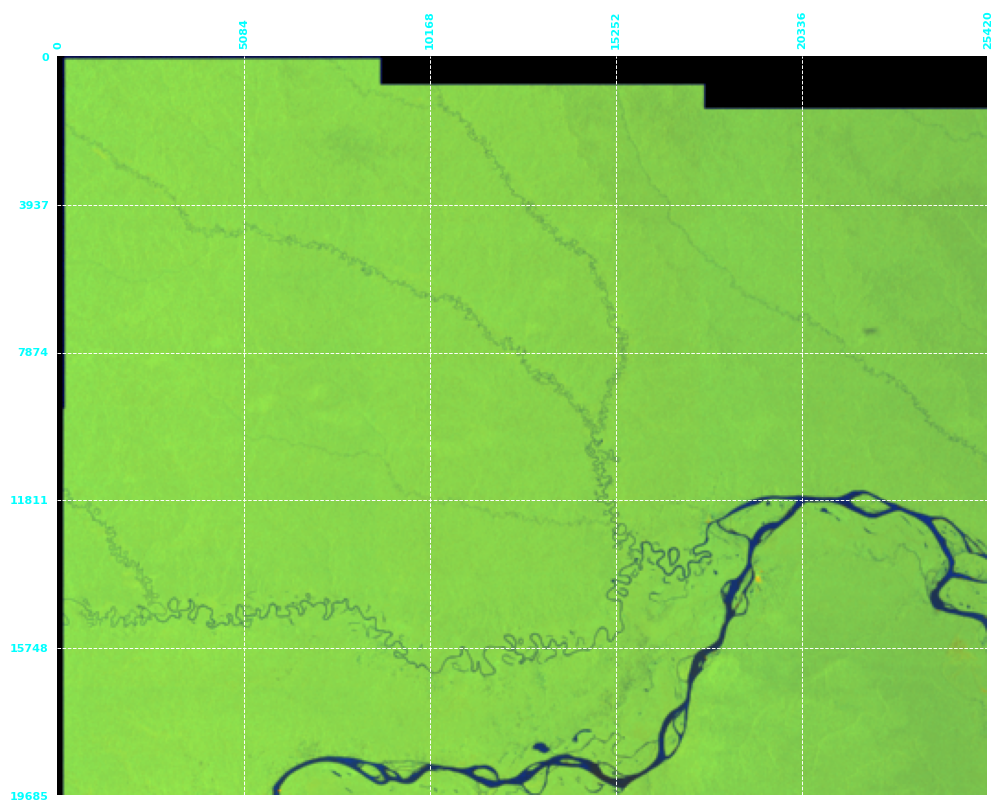

In [ ]:

# Abrir imagem quicklook
with ZipFile(input_S1_files[0], 'r') as qck_look:
    qck_look = qck_look.open(name[0] + '.SAFE/preview/quick-look.png')
    img = mpimg.imread(qck_look)

    # Dimensões do quicklook
    img_height, img_width = img.shape[0], img.shape[1]

    # Dimensões reais da imagem SAR
    real_height = height[0]
    real_width = width[0]

    # Número de linhas e colunas do grid
    n_rows = 5
    n_cols = 5
    cell_img_width = img_width / n_cols
    cell_img_height = img_height / n_rows
    cell_real_width = real_width // n_cols
    cell_real_height = real_height // n_rows

    # Criar figura
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img)
    ax.axis('off')
    #plt.title(f"Quicklook com eixos SAR reais - {name[0]}", fontsize=12, loc='left')

    # Adicionar valores nas bordas dos eixos
    for col in range(n_cols + 1):
        x = col * cell_img_width
        real_col = col * cell_real_width
        ax.text(x, -5, f"{real_col}", color='cyan', ha='center', va='bottom', fontsize=8, weight='bold', rotation=90)

    for row in range(n_rows + 1):
        y = row * cell_img_height
        real_row = row * cell_real_height
        ax.text(-5, y, f"{real_row}", color='cyan', ha='right', va='center', fontsize=8, weight='bold')

    # Desenhar o grid
    for i in range(1, n_cols):
        ax.axvline(i * cell_img_width, color='white', linestyle='--', linewidth=0.7)
    for j in range(1, n_rows):
        ax.axhline(j * cell_img_height, color='white', linestyle='--', linewidth=0.7)

    plt.show()

Tamanho real de cada célula: 5084.40 x 3937.20 unidades
Tamanho em pixels de cada célula: 101.20 x 80.20 pixels


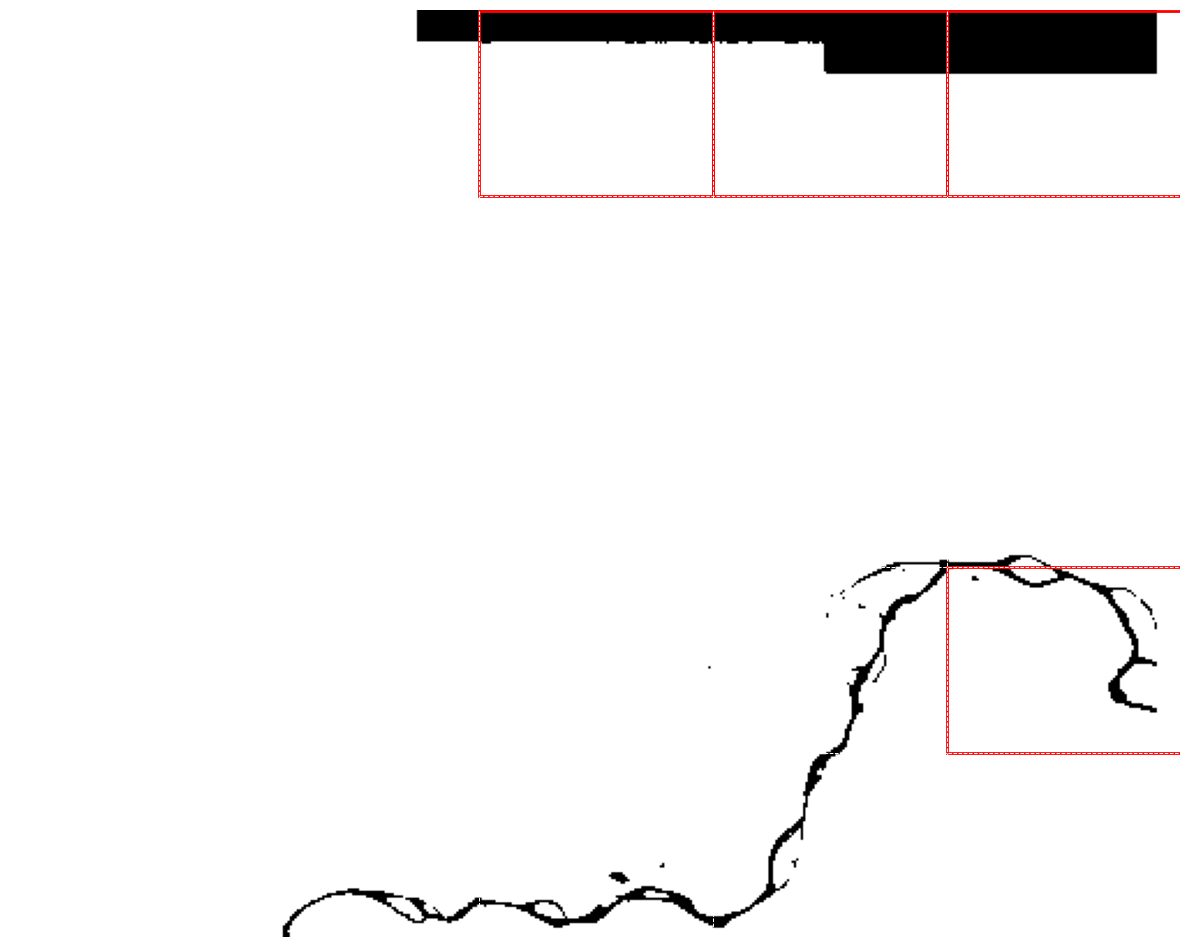

Quadrantes com mais de 5% de pixels pretos (linha, coluna):
 → Linha 0 | Coluna 2
 → Linha 0 | Coluna 3
 → Linha 0 | Coluna 4
 → Linha 3 | Coluna 4

Informações de conversão:
Resolução vertical: 49.0923 unidades/pixel
Resolução horizontal: 50.2411 unidades/pixel


In [ ]:
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.patches as patches

# Abrir imagem quicklook
with ZipFile(input_S1_files[0], 'r') as qck_look:
    qck_look = qck_look.open(name[0] + '.SAFE/preview/quick-look.png')
    img = mpimg.imread(qck_look)

    # Converter para escala de cinza
    if img.ndim == 3:
        img_gray = np.mean(img, axis=2)
    else:
        img_gray = img

    # Normalizar (0-255)
    if img_gray.max() <= 1.0:
        img_gray = (img_gray * 255).astype(np.uint8)

    # Aplicar Otsu
    limiar = threshold_otsu(img_gray)
    mascara_binaria = (img_gray > limiar).astype(np.uint8)
    mascara_binaria[:, :5] = 1   # primeiras 3 colunas
    mascara_binaria[:, -10:] = 1 # últimas 3 colunas


    def cortar_bordas_parcialmente_pretas(mascara, percentual_limiar=0.95, max_borda=100):
        linhas, colunas = mascara.shape

        # ----- TOPO -----
        topo = 0
        for i in range(min(max_borda, linhas)):
            if np.mean(mascara[i, :] == 0) >= percentual_limiar:
                topo = i + 1
            else:
                break

        # ----- BASE -----
        base = linhas
        for i in range(1, min(max_borda, linhas)):
            if np.mean(mascara[-i, :] == 0) >= percentual_limiar:
                base = linhas - i
            else:
                break

        # ----- ESQUERDA (faixas verticais pretas à esquerda) -----
        esquerda = 0
        for i in range(min(max_borda, colunas)):
            if np.mean(mascara[:, i] == 0) >= percentual_limiar:
                esquerda = i + 1
            else:
                break

        # ----- DIREITA (faixas verticais pretas à direita) -----
        direita = colunas
        for i in range(1, min(max_borda, colunas)):
            if np.mean(mascara[:, -i] == 0) >= percentual_limiar:
                direita = colunas - i
            else:
                break

        # Cortar imagem
        return mascara[topo:base, esquerda:direita]

    # Aplicar corte robusto
    mascara_binaria_cortada = cortar_bordas_parcialmente_pretas(mascara_binaria, percentual_limiar=0.95, max_borda=150)

    # Dimensões da imagem cortada
    img_height, img_width = mascara_binaria_cortada.shape

    # Dimensões reais da imagem SAR (em metros ou outra unidade)
    real_height = height[0]  # Substitua pela sua variável real
    real_width = width[0]    # Substitua pela sua variável real

    # Calcular a relação pixel/unidade real
    pixel_to_real_height = real_height / img_height
    pixel_to_real_width = real_width / img_width

    # Definir grid com base nas dimensões reais
    # Por exemplo, dividir em 10 partes iguais em cada dimensão
    n_rows = 5
    n_cols = 5

    # Tamanho de cada célula em unidades reais
    cell_real_width = real_width / n_cols
    cell_real_height = real_height / n_rows

    # Tamanho de cada célula em pixels (para visualização)
    cell_img_width = img_width / n_cols
    cell_img_height = img_height / n_rows

    print(f"Tamanho real de cada célula: {cell_real_width:.2f} x {cell_real_height:.2f} unidades")
    print(f"Tamanho em pixels de cada célula: {cell_img_width:.2f} x {cell_img_height:.2f} pixels")

    # Verificar quadrantes com >2% de pixels pretos
    quadrantes_com_pretos = []

    for row in range(n_rows):
        for col in range(n_cols):
            y_ini = int(row * cell_img_height)
            y_fim = int((row + 1) * cell_img_height)
            x_ini = int(col * cell_img_width)
            x_fim = int((col + 1) * cell_img_width)

            celula = mascara_binaria_cortada[y_ini:y_fim, x_ini:x_fim]
            total_pixels = celula.size
            n_pretos = np.count_nonzero(celula == 0)
            percentual_pretos = (n_pretos / total_pixels) * 100

            if percentual_pretos > 5:  # Limiar de 5%
                quadrantes_com_pretos.append((row, col))

    # --- Visualizar resultado final ---
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(mascara_binaria_cortada, cmap='gray')
    ax.axis('off')

    # Grid (em pixels, para visualização)
    for col in range(1, n_cols):
        ax.axvline(col * cell_img_width, color='white', linestyle='--', linewidth=0.7)
    for row in range(1, n_rows):
        ax.axhline(row * cell_img_height, color='white', linestyle='--', linewidth=0.7)

    # Destacar quadrantes com >5% preto
    for row, col in quadrantes_com_pretos:
        rect = patches.Rectangle(
            (col * cell_img_width, row * cell_img_height),
            cell_img_width, cell_img_height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

    # Mostrar resultado no console
    print("Quadrantes com mais de 5% de pixels pretos (linha, coluna):")
    for q in quadrantes_com_pretos:
        print(f" → Linha {q[0]} | Coluna {q[1]}")

    # Mostrar informações de conversão
    print(f"\nInformações de conversão:")
    print(f"Resolução vertical: {pixel_to_real_height:.4f} unidades/pixel")
    print(f"Resolução horizontal: {pixel_to_real_width:.4f} unidades/pixel")

C:\Users\lopez\AppData\Local\Temp\ipykernel_17172\2072118700.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


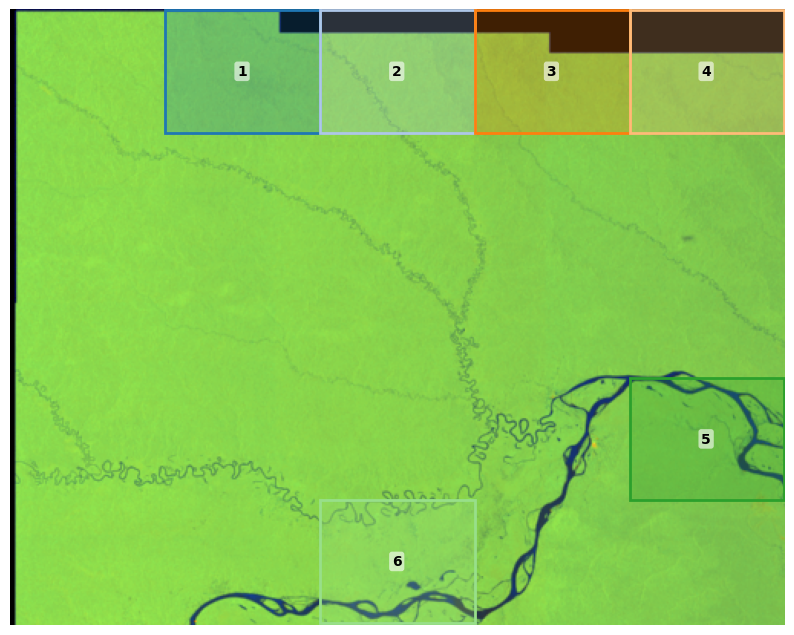

In [ ]:
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.patches as patches
import csv

# Dimensões reais da imagem SAR (substitua conforme necessário)
real_width = width[0]
real_height = height[0]

# Abrir imagem quicklook
with ZipFile(input_S1_files[0], 'r') as zf:
    with zf.open(name[0] + '.SAFE/preview/quick-look.png') as qck:
        img = mpimg.imread(qck)

# Usar a máscara completa (sem correção de bordas)
img_height, img_width = mascara_binaria.shape

# Grid
n_rows = 5
n_cols = 5
overlap_percent = 0

# Dimensões das células
cell_img_width = img_width / n_cols
cell_img_height = img_height / n_rows

step_x = int(cell_img_width * (1 - overlap_percent))
step_y = int(cell_img_height * (1 - overlap_percent))

cell_real_width = real_width / n_cols
cell_real_height = real_height / n_rows

quadrantes = []

# Figura de fundo
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')

# Colormap para cores distintas
cmap = plt.cm.get_cmap('tab20')

qid = 1  # contador de quadrantes
for row in range(0, img_height - int(cell_img_height) + 1, step_y):
    for col in range(0, img_width - int(cell_img_width) + 1, step_x):
        y_ini = row
        y_fim = row + int(cell_img_height)
        x_ini = col
        x_fim = col + int(cell_img_width)

        celula = mascara_binaria[y_ini:y_fim, x_ini:x_fim]
        percentual_pretos = (np.count_nonzero(celula == 0) / celula.size) * 100

        # Coordenadas reais
        x_real = (x_ini / img_width) * real_width
        y_real = (y_ini / img_height) * real_height

        if percentual_pretos > 5:
            color = cmap((qid - 1) % cmap.N)

            # Retângulo colorido (borda e preenchimento semi-transparente)
            rect = patches.Rectangle(
                (x_ini, y_ini),
                int(cell_img_width),
                int(cell_img_height),
                linewidth=2,
                edgecolor=color,
                facecolor=(color[0], color[1], color[2], 0.25)  # alpha ~ 0.25
            )
            ax.add_patch(rect)

            # Número do quadrante no centro da célula
            cx = x_ini + int(cell_img_width) // 2
            cy = y_ini + int(cell_img_height) // 2
            ax.text(cx, cy, str(qid), ha='center', va='center',
                    fontsize=10, fontweight='bold', color='black',
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.6))

            quadrante = {
                "quadrant_id": qid,
                "x": int(x_real),
                "y": int(y_real),
                "width": int(cell_real_width),
                "height": int(cell_real_height)
            }
            quadrantes.append(quadrante)
            qid += 1

# Mostrar o resultado
ax.axis('off')
plt.show()

# Salvar CSV com ID do quadrante
with open("quadrantes_problematicos.csv", mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["quadrant_id", "x", "y", "width", "height"])
    writer.writeheader()
    writer.writerows(quadrantes)


In [ ]:
import pandas as pd
import os

# Caminho do CSV salvo anteriormente
csv_path = "C:/Users/lopez/quadrantes_problematicos.csv"

# Nome base do produto original
nome_base = name[0]


# Pasta de saída
output_dir = 'C:/Users/lopez/ESA_SNAPPY/teste3'
os.makedirs(output_dir, exist_ok=True)

# Leitura dos quadrantes
df = pd.read_csv(csv_path)

for i, row in df.iterrows():
    x = int(row['x'])
    y = int(row['y'])
    width = int(row['width'])
    height = int(row['height'])

    print(colored(f"Recortando quadrante {i}: ({x}, {y}, {width}, {height})", 'yellow'))

    # Subset
    parameters = esa_snappy.HashMap()
    parameters.put('copyMetadata', True)
    parameters.put('region', f"{x},{y},{width},{height}")
    subset = esa_snappy.GPF.createProduct('Subset', parameters, s1_read)

    # Processamento do pipeline para cada subset
    # 1. Apply Orbit File
    parameters = esa_snappy.HashMap()
    parameters.put('Apply-Orbit-File', True)
    apply_orbit = esa_snappy.GPF.createProduct('Apply-Orbit-File', parameters, subset)

    # 2. Thermal Noise Removal
    parameters = esa_snappy.HashMap()
    parameters.put('removeThermalNoise', True)
    thermal_noise = esa_snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, apply_orbit)

    # 3. Calibration
    parameters = esa_snappy.HashMap()
    parameters.put('outputSigmaBand', True)
    parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
    parameters.put('selectedPolarisations', 'VH,VV')
    #parameters.put('sourceBands', 'Intensity_HH,Intensity_HV')
    #parameters.put('selectedPolarisations', 'HH,HV')
    parameters.put('outputImageScaleInDb', False)
    calibrated = esa_snappy.GPF.createProduct("Calibration", parameters, thermal_noise)

    # 4. Speckle Filter
    #Integer = jpy.get_type('java.lang.Integer')
    #parameters = esa_snappy.HashMap()
    #parameters.put('filter', 'Lee')
    #parameters.put('filterSizeX', Integer(4))
    #parameters.put('filterSizeY', Integer(4))
    #speckle = esa_snappy.GPF.createProduct('Speckle-Filter', parameters, calibrated)

    # 5. Terrain Correction
    parameters = esa_snappy.HashMap()
    parameters.put('demName', 'SRTM 3Sec')
    parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('pixelSpacingInMeter', 10.0)
    parameters.put('nodataValueAtSea', False)
    parameters.put('saveSelectedSourceBand', True)
    parameters.put('saveDEM', False)
    terrain_correction = esa_snappy.GPF.createProduct('Terrain-Correction', parameters, calibrated)



    # Forçar NoData = 0
    for band_name in terrain_correction.getBandNames():
        band = terrain_correction.getBand(band_name)
        band.setNoDataValue(0.0)
        band.setNoDataValueUsed(True)



    # Salvar em GeoTIFF
    output_path_tif = os.path.join(output_dir, f"{nome_base}_recorte_{i:03}_tif")
    esa_snappy.ProductIO.writeProduct(terrain_correction, output_path_tif, 'GeoTIFF')

    print(colored(f"Recorte {i} salvo com sucesso!", 'green'))


Recortando quadrante 0: (20297, 11752, 5084, 3937)
Recorte 0 salvo com sucesso!
Recortando quadrante 1: (10148, 15670, 5084, 3937)
Recorte 1 salvo com sucesso!


In [ ]:
##################### processa_todos_em_subpastas_por_imagem #####################

import os
import glob
import numpy as np
import rasterio
from rasterio.windows import Window
from PIL import Image

# ===================== PARÂMETROS ===================== #
#output_dir = r'C:\Users\lopez\ESA_SNAPPY\recortes_D_1'
in_dir  = output_dir   # pasta com os .tif/.tiff de entrada
#in_dir = output_dir = 'C:/Users/lopez/ESA_SNAPPY/recortes_L_26'# Processamento do pipeline para cada subset
out_dir = os.path.join(in_dir, 'saidas_batch')     # pasta raiz de saída
os.makedirs(out_dir, exist_ok=True)

# Percentis para normalização robusta (sem clipping explícito)
percentile_low  = 2.0
percentile_high = 98.0   # mude para 95.0 se preferir P2–P95

# Recortes
crop_size = 320
overlap_percent = 0.20
step = max(1, int(crop_size * (1 - overlap_percent)))   # garante passo >= 1

# Salvar formatos
save_jpg = True
save_tif = True

EPS = 1e-9
# ====================================================== #

def process_one_image(img_path):
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # protege contra reprocessar arquivos de saída (_crop_)
    if '_crop_' in base_name:
        print(f"[SKIP] Arquivo de saída detectado: {base_name}")
        return 0

    # --- subpastas por imagem ---
    img_out_dir = os.path.join(out_dir, base_name)
    jpg_dir = os.path.join(img_out_dir, 'jpg')
    tif_dir = os.path.join(img_out_dir, 'tif')
    if save_jpg: os.makedirs(jpg_dir, exist_ok=True)
    if save_tif: os.makedirs(tif_dir, exist_ok=True)

    with rasterio.open(img_path) as src:
        band = src.read(1).astype(np.float32)
        nodata_val = src.nodata
        height, width = src.shape
        src_profile = src.profile
        src_transform = src.transform
        src_crs = src.crs

    # Máscara de válidos (preserva NoData)
    if nodata_val is not None and np.isfinite(nodata_val):
        valid_mask = band != nodata_val
    else:
        # comum em SAR processado: zero como fundo
        valid_mask = band > 0

    band_clean = np.where(valid_mask, band, np.nan)
    if not np.any(np.isfinite(band_clean)):
        print(f"[SKIP] Sem pixels válidos: {base_name}")
        return 0

    # ---------- NORMALIZAÇÃO POR PERCENTIS (sem dB, sem clipping β·max) ----------
    p_low  = float(np.nanpercentile(band_clean, percentile_low))
    p_high = float(np.nanpercentile(band_clean, percentile_high))
    if not np.isfinite(p_low):  p_low  = float(np.nanmin(band_clean))
    if not np.isfinite(p_high): p_high = float(np.nanmax(band_clean))
    if p_high - p_low < EPS:
        p_high = p_low + EPS

    # aplica clip aos percentis e normaliza para [0,1]
    band_norm = (np.clip(band_clean, p_low, p_high) - p_low) / (p_high - p_low)
    band_norm = np.clip(band_norm, 0.0, 1.0)  # pronto p/ rede (float32 em [0,1])

    # ---------------------------------------------------------------------------

    # Loop de recortes e salvamento
    count = 0
    for y in range(0, height, step):
        for x in range(0, width, step):
            win_w = min(crop_size, width - x)
            win_h = min(crop_size, height - y)
            if win_w <= 0 or win_h <= 0:
                continue

            crop = band_norm[y:y+win_h, x:x+win_w].astype(np.float32)

            # pula recortes sem dados (todos NaN)
            if not np.any(np.isfinite(crop)):
                continue

            # ====== JPG (8-bit) a partir da imagem normalizada [0,1] ======
            if save_jpg:
                crop_u8  = (np.nan_to_num(crop, nan=0.0) * 255).astype(np.uint8)
                crop_rgb = np.dstack([crop_u8]*3)  # 3 canais para compatibilidade
                out_crop_jpg = os.path.join(jpg_dir, f'{base_name}_crop_{count+1:05d}.jpg')
                Image.fromarray(crop_rgb).save(out_crop_jpg, quality=95, optimize=True)

            # ====== GeoTIFF (float32 [0,1], georreferenciado) ======
            if save_tif:
                crop_to_write = crop.copy()
                profile = src_profile.copy()
                profile.update({
                    "driver": "GTiff",
                    "height": win_h,
                    "width": win_w,
                    "transform": rasterio.windows.transform(Window(x, y, win_w, win_h), src_transform),
                    "count": 1,
                    "dtype": rasterio.float32,
                    "crs": src_crs,
                    "compress": "LZW"
                })

                # converte NaN de volta para nodata, se o dataset definir
                if nodata_val is not None and np.isfinite(nodata_val):
                    profile.update({"nodata": nodata_val})
                    nan_mask = ~np.isfinite(crop_to_write)
                    if np.any(nan_mask):
                        crop_to_write[nan_mask] = nodata_val
                else:
                    profile.update({"nodata": None})
                    # opcional: manter NaN mesmo

                out_crop_tif = os.path.join(tif_dir, f'{base_name}_crop_{count+1:05d}.tif')
                with rasterio.open(out_crop_tif, 'w', **profile) as dst:
                    dst.write(crop_to_write, 1)

            count += 1

    print(f"[OK] {base_name}: {count} recortes salvos em {img_out_dir}")
    return count

def main():
    # Lista TIFs/TIFFs recursivamente
    patterns = ["*.tif", "*.tiff", "*.TIF", "*.TIFF"]
    tif_paths = []
    for p in patterns:
        tif_paths.extend(glob.glob(os.path.join(in_dir, '**', p), recursive=True))
    tif_paths = sorted(set(tif_paths))

    # 1) exclui a pasta de saída
    out_abs = os.path.abspath(out_dir)
    tif_paths = [p for p in tif_paths if not os.path.abspath(p).startswith(out_abs)]
    # 2) exclui arquivos de saída (já recortados)
    tif_paths = [p for p in tif_paths if '_crop_' not in os.path.basename(p)]

    if not tif_paths:
        print(f"[ERRO] Nenhum .tif/.tiff encontrado em: {in_dir}")
        return

    total_crops = 0
    for path in tif_paths:
        try:
            total_crops += process_one_image(path)
        except Exception as e:
            print(f"[ERRO] Falha ao processar {os.path.basename(path)}: {e}")

    print(f"\n[RESUMO] Imagens processadas: {len(tif_paths)} | Recortes totais: {total_crops}")
    print(f"[SAÍDA] {out_dir} (subpastas por imagem em 'jpg/' e 'tif/')")

if __name__ == "__main__":
    main()


[OK] S1C_IW_GRDH_1SDV_20251018T230217_20251018T230247_004622_009248_E8C4_COG_recorte_000_tif: 359 recortes salvos em C:/Users/lopez/ESA_SNAPPY/teste3\saidas_batch\S1C_IW_GRDH_1SDV_20251018T230217_20251018T230247_004622_009248_E8C4_COG_recorte_000_tif
[OK] S1C_IW_GRDH_1SDV_20251018T230217_20251018T230247_004622_009248_E8C4_COG_recorte_001_tif: 363 recortes salvos em C:/Users/lopez/ESA_SNAPPY/teste3\saidas_batch\S1C_IW_GRDH_1SDV_20251018T230217_20251018T230247_004622_009248_E8C4_COG_recorte_001_tif

[RESUMO] Imagens processadas: 2 | Recortes totais: 722
[SAÍDA] C:/Users/lopez/ESA_SNAPPY/teste3\saidas_batch (subpastas por imagem em 'jpg/' e 'tif/')
